In [1]:
# Install the OpenSlide C library and Python bindings
# After installing these libraries, use `Runtime -> restart and run all` on the menu
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 20 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 1s (184 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 124016 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2

In [8]:
#@title Load Package

import gc
import re
import os
import random
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, losses
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.utils import plot_model

seed = 1
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from openslide import open_slide, __library_version__ as openslide_version
from PIL import Image
from skimage.color import rgb2gray

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#@title Load custom functions

import sys
sys.path.insert(0, '/content/drive/MyDrive/Colab Notebooks/ADL/project')

from config import RAW_DATA_DIR, PROCESSED_DATA_DIR, POS_DATA_DIR, NEG_DATA_DIR, MODEL_DIR, RES_DIR
from processing import read_full_image, allocate_ones, allocate_zeros, get_patches_from_center, get_target, delete_gray
from create_model import create_base_model, create_one_zoom_model, create_three_zooms_model
from plot_heatmap import label_prediction, label_heatmap_multizooms

train_file = ["101", "094", "110", "016", "078", "031", "064"]
test_file = ["091", "075", "094", "084"]

In [5]:
test_file = ["091", "075", "094", "084"]
sampling_times = 5
nsamples = 200

In [ ]:
#@title Base Model

model = create_base_model()

checkpoint_path = os.path.join(MODEL_DIR, "model_5_200.ckpt")
# Loads the weights
model.load_weights(checkpoint_path)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 297, 297, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 148, 148, 16)     0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 350464)            0         
                                                                 
 dense (Dense)               (None, 32)                11214880  
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 11,215,361
Trainable params: 11,215,361
Non-trainable params: 0
____________________________________________

In [ ]:
true_label_lst = []
pred_res_lst = []
pred_label_lst = []

for slide_num in test_file:
  for s_i in range(sampling_times):
    print("\nPredict for", slide_num, s_i)

    # negative samples
    pos_file = os.path.join(POS_DATA_DIR, f"{slide_num}_567_{s_i}.npy")
    
    if not os.path.exists(pos_file):
      print(f"!!! No {pos_file}, please check!!!")
    
    else:
      print("------Load samples-------")
      pos_pitch_lst = np.load(pos_file)[0]

      pred_res = model.predict(pos_pitch_lst)
      pred_res_lst.extend(pred_res.reshape(-1))
      pred_label = (pred_res > 0.5).astype("int32")
      pred_label_lst.extend(pred_label.reshape(-1))
      true_label_lst.extend([1]*len(pred_label))

    # negative samples
    neg_file = os.path.join(NEG_DATA_DIR, f"{slide_num}_567_{s_i}.npy")

    if not os.path.exists(neg_file):
      print(f"!!! No {neg_file}, please check!!!")

    else:
      print("------Load samples-------")
      neg_pitch_lst = np.load(neg_file)[0]

      pred_res = model.predict(neg_pitch_lst)
      pred_res_lst.extend(pred_res.reshape(-1))
      pred_label = (pred_res > 0.5).astype("int32")    
      pred_label_lst.extend(pred_label.reshape(-1))
      true_label_lst.extend([0]*len(pred_label))

target_names = ['normal', 'cancer']
print(classification_report(true_label_lst, pred_label_lst, target_names=target_names))

prediction_df = pd.DataFrame({
    "true_label_lst": true_label_lst,
    "pred_res_lst": pred_res_lst,
    "pred_label_lst": pred_label_lst
})

print("Save prediction")
prediction_file = os.path.join(RES_DIR, "pred_5_200.csv")
prediction_df.to_csv(prediction_file, index=False)



Predict for 091 0
------Load samples-------
7/7 [==============================] - 2s 30ms/step
------Load samples-------
7/7 [==============================] - 0s 21ms/step

Predict for 091 1
------Load samples-------
7/7 [==============================] - 0s 21ms/step
------Load samples-------
7/7 [==============================] - 0s 20ms/step

Predict for 091 2
------Load samples-------
7/7 [==============================] - 0s 21ms/step
------Load samples-------
7/7 [==============================] - 0s 20ms/step

Predict for 091 3
------Load samples-------
7/7 [==============================] - 0s 20ms/step
------Load samples-------
7/7 [==============================] - 0s 21ms/step

Predict for 091 4
------Load samples-------
7/7 [==============================] - 0s 20ms/step
------Load samples-------
7/7 [==============================] - 0s 20ms/step

Predict for 075 0
------Load samples-------
7/7 [==============================] - 0s 20ms/step
------Load samples-------
7/

In [ ]:
#@title One-zoom Model (5)

model = create_one_zoom_model()

checkpoint_path = os.path.join(MODEL_DIR, "model_onezoom_5_200.ckpt")
# Loads the weights
model.load_weights(checkpoint_path)

87910968/87910968 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 2048)              21802784  
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 32)                4128      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                              

In [ ]:
true_label_lst = []
pred_res_lst = []
pred_label_lst = []

for slide_num in test_file:
  for s_i in range(sampling_times):
    print("\nPredict for", slide_num, s_i)

    # negative samples
    pos_file = os.path.join(POS_DATA_DIR, f"{slide_num}_567_{s_i}.npy")
    
    if not os.path.exists(pos_file):
      print(f"!!! No {pos_file}, please check!!!")
    
    else:
      print("------Load samples-------")
      pos_pitch_lst = np.load(pos_file)[0]

      pred_res = model.predict(pos_pitch_lst)
      pred_res_lst.extend(pred_res.reshape(-1))
      pred_label = (pred_res > 0.5).astype("int32")
      pred_label_lst.extend(pred_label.reshape(-1))
      true_label_lst.extend([1]*len(pred_label))

    # negative samples
    neg_file = os.path.join(NEG_DATA_DIR, f"{slide_num}_567_{s_i}.npy")

    if not os.path.exists(neg_file):
      print(f"!!! No {neg_file}, please check!!!")

    else:
      print("------Load samples-------")
      neg_pitch_lst = np.load(neg_file)[0]

      pred_res = model.predict(neg_pitch_lst)
      pred_res_lst.extend(pred_res.reshape(-1))
      pred_label = (pred_res > 0.5).astype("int32")    
      pred_label_lst.extend(pred_label.reshape(-1))
      true_label_lst.extend([0]*len(pred_label))

target_names = ['normal', 'cancer']
print(classification_report(true_label_lst, pred_label_lst, target_names=target_names))

prediction_df = pd.DataFrame({
    "true_label_lst": true_label_lst,
    "pred_res_lst": pred_res_lst,
    "pred_label_lst": pred_label_lst
})

print("Save prediction")
prediction_file = os.path.join(RES_DIR, "pred_onezoom_5_200.csv")
prediction_df.to_csv(prediction_file, index=False)



Predict for 091 0
------Load samples-------
7/7 [==============================] - 5s 273ms/step
------Load samples-------
7/7 [==============================] - 1s 116ms/step

Predict for 091 1
------Load samples-------
7/7 [==============================] - 1s 117ms/step
------Load samples-------
7/7 [==============================] - 1s 121ms/step

Predict for 091 2
------Load samples-------
7/7 [==============================] - 1s 121ms/step
------Load samples-------
7/7 [==============================] - 1s 118ms/step

Predict for 091 3
------Load samples-------
7/7 [==============================] - 1s 120ms/step
------Load samples-------
7/7 [==============================] - 1s 121ms/step

Predict for 091 4
------Load samples-------
7/7 [==============================] - 1s 121ms/step
------Load samples-------
7/7 [==============================] - 1s 117ms/step

Predict for 075 0
------Load samples-------
7/7 [==============================] - 1s 118ms/step
------Load sample

In [ ]:
#@title Three-zooms Model (567)

model = create_three_zooms_model()

checkpoint_path = os.path.join(MODEL_DIR, "model_567_200.ckpt")
# Loads the weights
model.load_weights(checkpoint_path)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input1 (InputLayer)            [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 input2 (InputLayer)            [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 input3 (InputLayer)            [(None, 299, 299, 3  0           []                               
                                )]                                                          

In [ ]:
true_label_lst = []
pred_res_lst = []
pred_label_lst = []

for slide_num in test_file:
  for s_i in range(sampling_times):
    print("\nPredict for", slide_num, s_i)

    # negative samples
    pos_file = os.path.join(POS_DATA_DIR, f"{slide_num}_567_{s_i}.npy")
    
    if not os.path.exists(pos_file):
      print(f"!!! No {pos_file}, please check!!!")
    
    else:
      print("------Load samples-------")
      pos_pitch_lst = np.load(pos_file)
      input_dict = {
          "input1": pos_pitch_lst[0],
          "input2": pos_pitch_lst[1],
          "input3": pos_pitch_lst[2],
      }

      pred_res = model.predict(input_dict)

      del pos_pitch_lst
      gc.collect()

      pred_res_lst.extend(pred_res.reshape(-1))
      pred_label = (pred_res > 0.5).astype("int32")
      pred_label_lst.extend(pred_label.reshape(-1))
      true_label_lst.extend([1]*len(pred_label))

    # negative samples
    neg_file = os.path.join(NEG_DATA_DIR, f"{slide_num}_567_{s_i}.npy")

    if not os.path.exists(neg_file):
      print(f"!!! No {neg_file}, please check!!!")

    else:
      print("------Load samples-------")
      neg_pitch_lst = np.load(neg_file)

      input_dict = {
          "input1": neg_pitch_lst[0],
          "input2": neg_pitch_lst[1],
          "input3": neg_pitch_lst[2],
      }

      pred_res = model.predict(input_dict)

      del input_dict
      gc.collect()

      pred_res_lst.extend(pred_res.reshape(-1))
      pred_label = (pred_res > 0.5).astype("int32")    
      pred_label_lst.extend(pred_label.reshape(-1))
      true_label_lst.extend([0]*len(pred_label))

target_names = ['normal', 'cancer']
print(classification_report(true_label_lst, pred_label_lst, target_names=target_names))

prediction_df = pd.DataFrame({
    "true_label_lst": true_label_lst,
    "pred_res_lst": pred_res_lst,
    "pred_label_lst": pred_label_lst
})

print("Save prediction")
prediction_file = os.path.join(RES_DIR, "pred_567_200.csv")
prediction_df.to_csv(prediction_file, index=False)



Predict for 091 0
------Load samples-------
7/7 [==============================] - 6s 322ms/step
------Load samples-------
7/7 [==============================] - 2s 322ms/step

Predict for 091 1
------Load samples-------
7/7 [==============================] - 2s 323ms/step
------Load samples-------
7/7 [==============================] - 2s 329ms/step

Predict for 091 2
------Load samples-------
7/7 [==============================] - 2s 326ms/step
------Load samples-------
7/7 [==============================] - 2s 323ms/step

Predict for 091 3
------Load samples-------
7/7 [==============================] - 2s 324ms/step
------Load samples-------
7/7 [==============================] - 2s 321ms/step

Predict for 091 4
------Load samples-------
7/7 [==============================] - 2s 325ms/step
------Load samples-------
7/7 [==============================] - 2s 323ms/step

Predict for 075 0
------Load samples-------
7/7 [==============================] - 2s 324ms/step
------Load sample

In [ ]:
#@title Three-zooms Model (357)

model = create_three_zooms_model()

checkpoint_path = os.path.join(MODEL_DIR, "model_357_200.ckpt")
# Loads the weights
model.load_weights(checkpoint_path)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input1 (InputLayer)            [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 input2 (InputLayer)            [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 input3 (InputLayer)            [(None, 299, 299, 3  0           []                               
                                )]                                                          

In [ ]:
true_label_lst = []
pred_res_lst = []
pred_label_lst = []

for slide_num in test_file:
  for s_i in range(sampling_times):
    print("\nPredict for", slide_num, s_i)

    # negative samples
    pos_file = os.path.join(POS_DATA_DIR, f"{slide_num}_357_{s_i}.npy")
    
    if not os.path.exists(pos_file):
      print(f"!!! No {pos_file}, please check!!!")
    
    else:
      print("------Load samples-------")
      pos_pitch_lst = np.load(pos_file)
      input_dict = {
          "input1": pos_pitch_lst[0],
          "input2": pos_pitch_lst[1],
          "input3": pos_pitch_lst[2],
      }

      pred_res = model.predict(input_dict)

      del pos_pitch_lst
      gc.collect()

      pred_res_lst.extend(pred_res.reshape(-1))
      pred_label = (pred_res > 0.5).astype("int32")
      pred_label_lst.extend(pred_label.reshape(-1))
      true_label_lst.extend([1]*len(pred_label))

    # negative samples
    neg_file = os.path.join(NEG_DATA_DIR, f"{slide_num}_357_{s_i}.npy")

    if not os.path.exists(neg_file):
      print(f"!!! No {neg_file}, please check!!!")

    else:
      print("------Load samples-------")
      neg_pitch_lst = np.load(neg_file)

      input_dict = {
          "input1": neg_pitch_lst[0],
          "input2": neg_pitch_lst[1],
          "input3": neg_pitch_lst[2],
      }

      pred_res = model.predict(input_dict)

      del input_dict
      gc.collect()

      pred_res_lst.extend(pred_res.reshape(-1))
      pred_label = (pred_res > 0.5).astype("int32")    
      pred_label_lst.extend(pred_label.reshape(-1))
      true_label_lst.extend([0]*len(pred_label))

target_names = ['normal', 'cancer']
print(classification_report(true_label_lst, pred_label_lst, target_names=target_names))

prediction_df = pd.DataFrame({
    "true_label_lst": true_label_lst,
    "pred_res_lst": pred_res_lst,
    "pred_label_lst": pred_label_lst
})

print("Save prediction")
prediction_file = os.path.join(RES_DIR, "pred_357_200.csv")
prediction_df.to_csv(prediction_file, index=False)



Predict for 091 0
------Load samples-------
7/7 [==============================] - 7s 351ms/step
------Load samples-------
7/7 [==============================] - 2s 348ms/step

Predict for 091 1
------Load samples-------
7/7 [==============================] - 2s 353ms/step
------Load samples-------
7/7 [==============================] - 2s 357ms/step

Predict for 091 2
------Load samples-------
7/7 [==============================] - 2s 357ms/step
------Load samples-------
7/7 [==============================] - 2s 348ms/step

Predict for 091 3
------Load samples-------
7/7 [==============================] - 2s 350ms/step
------Load samples-------
7/7 [==============================] - 2s 350ms/step

Predict for 091 4
------Load samples-------
7/7 [==============================] - 2s 353ms/step
------Load samples-------
7/7 [==============================] - 2s 351ms/step

Predict for 075 0
------Load samples-------
7/7 [==============================] - 2s 350ms/step
------Load sample

In [ ]:
#@title Load Data and make plots
prediction_file = os.path.join(RES_DIR, "pred_5_200.csv")
base_pred = pd.read_csv(prediction_file)
true_label_lst = base_pred["true_label_lst"]
base_pred_res_lst = base_pred["pred_res_lst"]

prediction_file = os.path.join(RES_DIR, "pred_onezoom_5_200.csv")
one_zoom_pred = pd.read_csv(prediction_file)
one_zoom_pred_res_lst = one_zoom_pred["pred_res_lst"]

prediction_file = os.path.join(RES_DIR, "pred_567_200.csv")
three_zoom_567_pred = pd.read_csv(prediction_file)
three_zoom_567_pred_res_lst = three_zoom_567_pred["pred_res_lst"]

prediction_file = os.path.join(RES_DIR, "pred_357_200.csv")
three_zoom_357_pred = pd.read_csv(prediction_file)
three_zoom_357_pred_res_lst = three_zoom_357_pred["pred_res_lst"]

In [ ]:
random_guess = [0] * len(pred_res_lst)

Random Guess: ROC AUC=0.500
Base Model: ROC AUC=0.698
One-zoom (5) Model: ROC AUC=0.775
Three-zooms (567) Model: ROC AUC=0.722
Three-zooms (357) Model: ROC AUC=0.535


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-pack

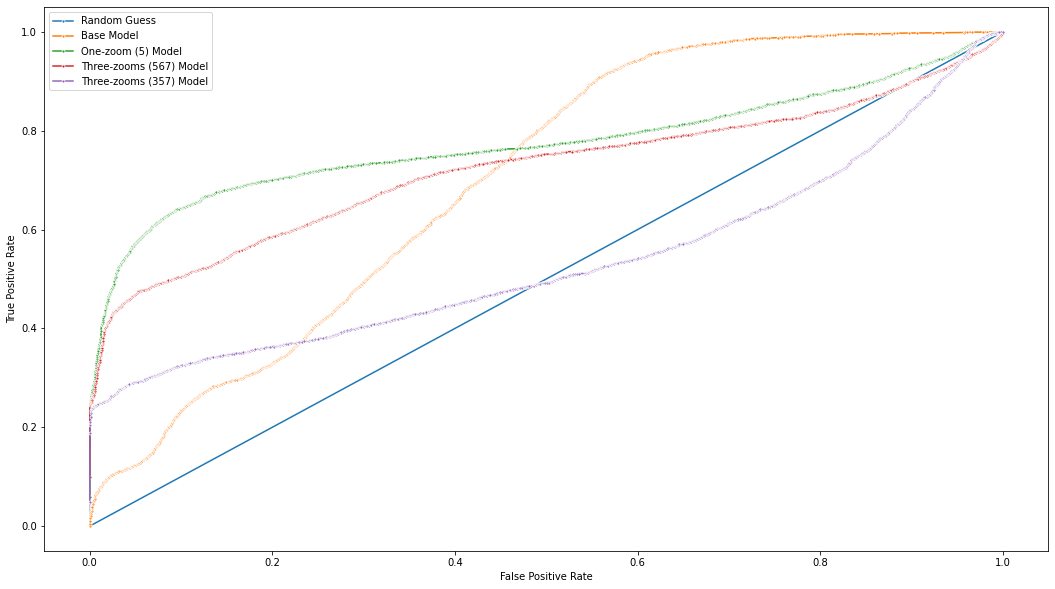

In [ ]:
# calculate scores
rg_auc = roc_auc_score(true_label_lst, random_guess)
base_auc = roc_auc_score(true_label_lst, base_pred_res_lst)
one_zoom_auc = roc_auc_score(true_label_lst, one_zoom_pred_res_lst)
three_zoom_567_auc = roc_auc_score(true_label_lst, three_zoom_567_pred_res_lst)
three_zoom_357_auc = roc_auc_score(true_label_lst, three_zoom_357_pred_res_lst)

# summarize scores
print('Random Guess: ROC AUC=%.3f' % (rg_auc))
print('Base Model: ROC AUC=%.3f' % (base_auc))
print('One-zoom (5) Model: ROC AUC=%.3f' % (one_zoom_auc))
print('Three-zooms (567) Model: ROC AUC=%.3f' % (three_zoom_567_auc))
print('Three-zooms (357) Model: ROC AUC=%.3f' % (three_zoom_357_auc))

fig, ax = plt.subplots(figsize=(18,10))

# calculate roc curves
rg_fpr, rg_tpr, _ = roc_curve(true_label_lst, random_guess)
base_fpr, base_tpr, _ = roc_curve(true_label_lst, base_pred_res_lst)
one_zoom_fpr, one_zoom_tpr, _ = roc_curve(true_label_lst, one_zoom_pred_res_lst)
three_zoom_567_fpr, three_zoom_567_tpr, _ = roc_curve(true_label_lst, three_zoom_567_pred_res_lst)
three_zoom_357_fpr, three_zoom_357_tpr, _ = roc_curve(true_label_lst, three_zoom_357_pred_res_lst)

# plot the roc curve for the model
sns.lineplot(rg_fpr, rg_tpr, marker='.', label='Random Guess')
sns.lineplot(base_fpr, base_tpr, marker='.', label='Base Model')
sns.lineplot(one_zoom_fpr, one_zoom_tpr, marker='.', label='One-zoom (5) Model')
sns.lineplot(three_zoom_567_fpr, three_zoom_567_tpr, marker='.', label='Three-zooms (567) Model')
sns.lineplot(three_zoom_357_fpr, three_zoom_357_tpr, marker='.', label='Three-zooms (357) Model')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()